# Development of polymer building, including monomer and bonding spec

## Port-binding rules

In [1]:
from rdkit import Chem
from rdkit.Chem import RWMol, BondType

from polysaccharide2 import rdutils
from polysaccharide2.rdutils import rdkdraw
from polysaccharide2.rdutils.rdtypes import RDAtom, RDBond, RDMol
from polysaccharide2.rdutils.labeling import atomwise, molwise
from polysaccharide2.rdutils.labeling.molwise import assign_ordered_atom_map_nums
from polysaccharide2.rdutils.amalgamation import _bonding, bonding, portlib, portlib_legacy

from polysaccharide2.genutils.decorators.functional import optional_in_place

/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-pdb-pr/lib/python3.11/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-pdb-pr/lib

In [2]:
# some "normal" molecules for testing
H  = Chem.MolFromSmarts('[#1]-[1#0]')
OH = Chem.MolFromSmarts('[#1]-[O]-[2#0]')
METHYL = Chem.MolFromSmarts('[#6](-[2#0])(-[2#0])(-[3#0])(-[1#0])')
CARBONYL = Chem.MolFromSmarts('[#6]-[#6](=[#8])-[1#0]')
WITTIG = Chem.MolFromSmarts('[#6](=[1#0])(-[2#0])(-[#1])')

TEST_MOLS_NORMAL = (
    H,
    OH,
    METHYL,
    WITTIG,
    CARBONYL
)

# Pathological examples for debug
DOUBLE_MID = Chem.MolFromSmarts('[#6](-[1#0])(-[#1])=[#0]-[#6](-[#1])(-[#1])(-[2#0])')
NEUTRONIUM = Chem.MolFromSmarts('[#0]-[#0]')
GHOST_WATER = Chem.MolFromSmarts('[#1]-[#0]-[#1]')

TEST_MOLS_PATHO = (
    DOUBLE_MID,
    NEUTRONIUM,
    GHOST_WATER
)

# COMBINE FOR UNIVERSAL TESTING
TEST_MOLS = (
    *TEST_MOLS_NORMAL,
    *TEST_MOLS_PATHO
)

1


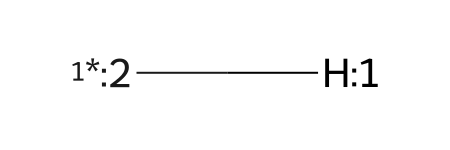

1


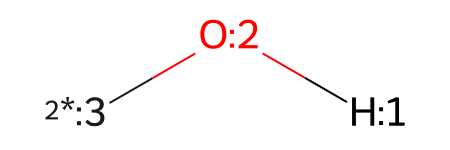

4


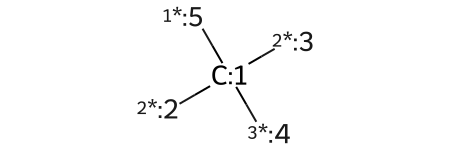

2


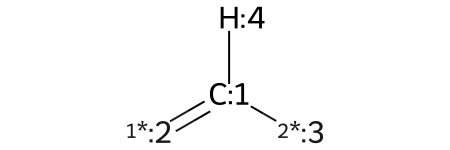

1


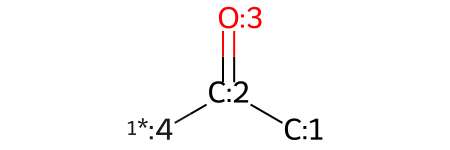

2


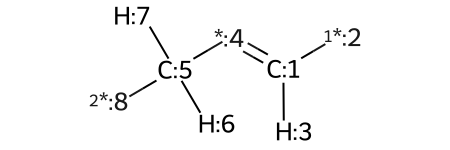

0


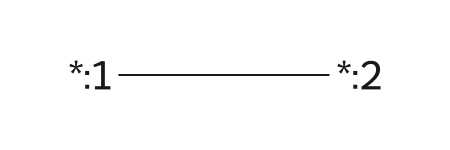

0


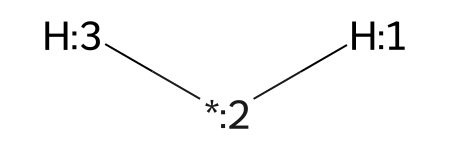

In [3]:
rdkdraw.disable_substruct_highlights()

for mol in TEST_MOLS:
    assign_ordered_atom_map_nums(mol, in_place=True)
    print(portlib.get_num_ports(mol))
    display(mol)

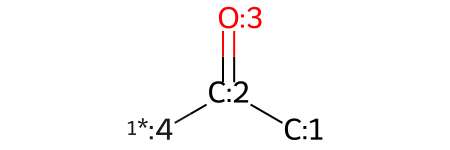

In [4]:
display(CARBONYL)

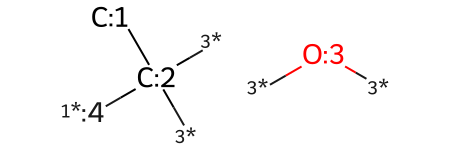

In [5]:
bonding.dissolve_bond(Chem.RWMol(CARBONYL), 1, 2, new_port_desig=3)

In [6]:
WITTIG_DUAL = Chem.MolFromSmarts('[#6](=[1#0])(-[#7](-[#1])(-[#1]))(-[#1])')

def combine_rdmols(rdmol_1 : RDMol, rdmol_2 : RDMol) -> RDMol:
    rdmol_1, rdmol_2 = molwise.assign_contiguous_atom_map_nums(rdmol_1, rdmol_2, in_place=False) 
    combo = Chem.CombineMols(rdmol_1, rdmol_2) # combine into single Mol object to allow for bonding
    combo = Chem.RWMol(combo) # make combined Mol modifiable

    atom_ids = [
        [port.bridgehead.GetIdx() for port in ports]
            for ports in portlib.get_bondable_port_pairs_internal(portlib.get_ports(combo))
    ]
    print(atom_ids)

    return bonding.increase_bond_order(combo, *atom_ids[0], in_place=False)
# m1, m2 = molwise.assign_contiguous_atom_map_nums(METHYL, OH, in_place=False)
# m1, m2 = molwise.assign_contiguous_atom_map_nums(METHYL, CARBONYL, in_place=False)

[[0, 4]]
[[0, 9]]


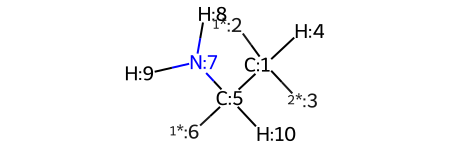

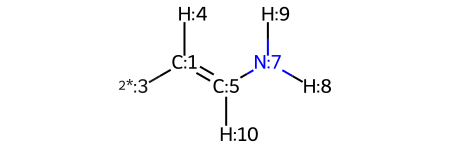

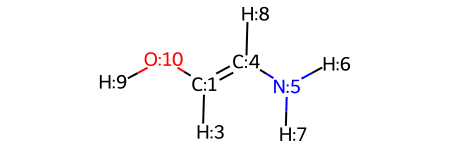

In [7]:
new_mol = combine_rdmols(WITTIG, WITTIG_DUAL)
new_mol_2 = bonding.increase_bond_order(new_mol, 0, 4, in_place=False)
new_mol_3 = combine_rdmols(new_mol_2, OH)

display(new_mol)
display(new_mol_2)
display(new_mol_3)

## Defining port combination and substitution rules

In [ ]:
from itertools import product as cartesian_product

def ports_are_bondable(port_1 : RDAtom, port_2 : RDAtom) -> bool:
    '''Determine if two port atoms can be combined into a bond'''
    port_info_1 = portlib_legacy.get_port_info(port_1)
    port_info_2 = portlib_legacy.get_port_info(port_2)

    return ( # to be bondable port, the pair must:
        port_info_1.port.GetIdx() != port_info_2.port.GetIdx()                        # not be the same port
        and port_info_1.bh_atom.GetIdx() != port_info_2.bh_atom.GetIdx()              # be bonded to different bridegehead atoms
        and port_info_1.desig == port_info_2.desig                                    # have compatible designations
        and port_info_1.inc_bond.GetBondType() ==  port_info_2.inc_bond.GetBondType() # have matching bond types
    )

def enumerate_fusable_ports(rdmol_1 : RDMol, rdmol_2 : RDMol, asAtoms : bool=True) -> list[tuple[int, int]]:
    '''Get all pairs of atoms between two Mols which have compatible neighboring ports
    Returns a dict with keys containing the bondable atoms and values containing the corresponding bond ports'''
    ports_dict_1 = portlib_legacy.get_mol_ports_dict(rdmol_1)
    ports_dict_2 = portlib_legacy.get_mol_ports_dict(rdmol_2)

    pairs_list = [
        (port_info_1.port, port_info_2.port)
            for mutual_desig in (ports_dict_1.keys() | ports_dict_2.keys()) # enumerate over pairs of ports which match designation
                for port_info_1, port_info_2 in cartesian_product(ports_dict_1[mutual_desig], ports_dict_2[mutual_desig]) # iterate over all pairs with matching designation
                    if ports_are_bondable(port_info_1.port, port_info_2.port)
    ]

    if not asAtoms:
        return [
            tuple(port.GetIdx() for port in port_pair)
                for port_pair in pairs_list
        ]
    return pairs_list

In [ ]:
from rdkit.Chem.rdchem import BondType, RWMol
from polysaccharide2.rdutils.rderrors import BondOrderModificationError
from polysaccharide2.rdutils.reactions.bonding_legacy import _decrease_bond_order

# UP-CONVERTING BONDS
def bond_order_increasable(rdmol : RDMol, *atom_pair_ids : list[int, int]) -> bool:
    '''Check if both atoms have a free neighboring port'''
    return all(
        portlib_legacy.has_neighbor_ports(rdmol.GetAtomWithIdx(atom_id))
            for atom_id in atom_pair_ids
    )

@optional_in_place
def fuse_ports(rwmol : RWMol, *port_map_nums : tuple[int, int]) -> None:
    '''Exchange two ports for a bond of one order higher in a modifiable RWMol'''
    if not portlib_legacy.ports_are_bondable(*ports):
        raise BondOrderModificationError
    
    # locate bridgehead atoms to bond, reduce port bond orders
    bh_atom_ids = []
    for port in ports:
        port_info = portlib_legacy.get_port_info(port)
        bh_atom_id = port_info.bh_atom.GetIdx()
        bh_atom_ids.append(bh_atom_id)

        _decrease_bond_order(rwmol, port.GetIdx(), bh_atom_id, in_place=True) # remove a bond between the port and the bridgehead
        
        port = rwmol.GetAtomWithIdx(port.GetIdx())
        print(atomwise.get_num_bonds(port))
        if atomwise.get_num_bonds(port) == 0:
            rwmol.RemoveAtom(port.GetIdx()) # delete port if decreasing bond order has now caused it to unbond completely

    # determine expected bond type after order increase (handle single-bond removal, specifically) 
    curr_bond = rwmol.GetBondBetweenAtoms(*bh_atom_ids)
    if curr_bond is None:
        new_bond_type = BondType.SINGLE # with no pre-existing bond, simply add a single bond
    else: 
        new_bond_type = BondType.values[curr_bond.GetBondTypeAsDouble() + 1] # with pre-existing bond, need to get the next order up by numeric lookup
        rwmol.RemoveBond(*bh_atom_ids) # also remove the existing bond for new bond creation

    # create new bond
    rwmol.AddBond(*bh_atom_ids, order=new_bond_type) # create new bond or specified order

In [ ]:
from polysaccharide2.rdutils.amalgamation import portlib_legacy
from polysaccharide2.rdutils.labeling import molwise

# mol = portlib.splice_port(METHYL, H)
# display(mol)
# OH     = Chem.MolFromSmarts('[#1D1+0:1]-[#8D2+0:2]-[3#0:3]')
# METHYL = Chem.MolFromSmarts('[#6D4+0:1](-[3#0:2])(-[2#0:3])(-[2#0:4])(-[1#0:5])')
OH     = Chem.MolFromSmiles('[#1+0:1]-[#8+0:2]-[3#0:3]', sanitize=False)
METHYL = Chem.MolFromSmiles('[#6+0:1](-[3#0:2])(-[2#0:3])(-[2#0:4])(-[1#0:5])', sanitize=False)
display(OH)
display(METHYL)
print('='*50)

# mol = portlib.saturate_ports(METHYL, OH)
# molwise.assign_ordered_atom_map_nums(mol, in_place=True)
# display(mol)

In [ ]:
for bond in METHYL.GetBonds():
    bond.SetProp()

In [ ]:
rdmol, sat_group = molwise.assign_contiguous_atom_map_nums(METHYL, OH, in_place=False) # VITAL that this is done first to ensure map
combo = Chem.CombineMols(rdmol, sat_group)
combo = Chem.RWMol(combo)

ports = enumerate_fusable_ports(rdmol, sat_group, asAtoms=True)
port_map_nums = [port.GetAtomMapNum() for port in ports[0]]
port_atoms = [combo.GetAtomWithIdx(i) for i in molwise.atom_ids_by_map_nums(combo, *port_map_nums)]

# Implementing monomer-spec SMARTS query assignment

In [ ]:
from polysaccharide2.rdutils.rdtypes import RDAtom, RDMol

def _get_compliant_atom_query(rdatom : RDAtom) -> Chem.QueryAtom:
    '''Generated monomer-specification-compliant atom query SMARTS string (<insert our citation eventually>) for a non-port atom'''
    assert(not portlib_legacy.is_port(atom)) # TODO : add special case for handling ports once port spec is solidified

    isotope      = rdatom.GetIsotope()
    atomic_num   = rdatom.GetAtomicNum()
    degree_num   = rdatom.GetDegree() # counts number of active bonds
    formal_chg   = rdatom.GetFormalCharge()
    atom_map_num = rdatom.GetAtomMapNum() # TODO : add check for nonzero map num   
    
    if isotope == 0:
        query_SMARTS = f'[#{atomic_num}D{degree_num}{formal_chg:+}:{atom_map_num}]'
    else:
        query_SMARTS = f'[{isotope}?#{atomic_num}D{degree_num}{formal_chg:+}:{atom_map_num}]'
    print(query_SMARTS)

    return Chem.AtomFromSmarts(query_SMARTS) # include explicit plus for positive formal charges

In [ ]:
PVC_SMARTS = "[1#0:7]-[#6D4+0:1](-[#1D1+0:2])(-[#1D1+0:3])-[#6D4+0:4](-[#17D1+0:5])(-[#1D1+0:6])-[2#0:14]"
PVC = Chem.MolFromSmarts(PVC_SMARTS)
PVC

In [ ]:
import re

MONOMER_ATOM_QUERY = re.compile(
    r'\[(?P<isotope>\d?)' \
    r'#(?P<atomic_num>\d+?)' \
    r'(?P<valence>.*?)' \
    r':(?P<map_num>\d+?)\]'
)

DEGREE_CHARGE_QUERY = re.compile(
    r'D(?P<degree>\d{1})' \
    r'[+-](?P<formal_charge>\d+)'
)

In [ ]:
for match in re.finditer(MONOMER_ATOM_QUERY, PVC_SMARTS):
    groups = match.groupdict()

    if groups.get('isotope') == '':
        groups['isotope'] = '0'

    if (valence := groups.get('valence')):
        atom_info = re.search(DEGREE_CHARGE_QUERY, valence).groupdict()
        groups.update(atom_info)
    groups.pop('valence') # discard for both linkers and non-linkers
    groups = {
        key : int(val)
            for key, val in groups.items() # convert to ints from strings
    }

    print(groups)

In [ ]:
METHYL = Chem.MolFromSmarts('[#6D4+0](-[3#0])(-[2#0])(-[4#0])(-[1#0])')
display(METHYL)
print(Chem.MolToSmiles(METHYL))
print(Chem.MolToSmarts(METHYL))

In [ ]:
mol = METHYL

for atom in mol.GetAtoms():
    if not portlib_legacy.is_port(atom):
        if atom.GetSymbol() == 'O':
            atom.SetIsotope(1)
        query_atom = _get_compliant_atom_query(atom)
        atom.SetQuery(query_atom)
        # print(_get_compliant_atom_query(atom))

display(mol)
print('RDKit-generated mol query : ', Chem.MolToSmarts(mol), Chem.MolToSmiles(mol))

In [ ]:
for atom in mol.GetAtoms():
    print(atom.GetSmarts())

In [ ]:
Chem.MolFromSmiles('[#6&D4&+0:1](-[#0&2*:2])(-[#0&2*:3])(-[#0&2*:4])-[#0&1*:5]')

In [ ]:
sm = Chem.MolToSmarts(mol)
sm = sm.replace('&', '')

mol2 = Chem.MolFromSmarts(sm)
display(mol2)

In [ ]:
block = Chem.MolToMolBlock(mol)

In [ ]:
import pandas as pd
from polysaccharide2.genutils.iteration import iter_len

records = []
for atom in mol.GetAtoms():
    record = {
        'symbol' : atom.GetSymbol(),
        'map num' : atom.GetAtomMapNum(),
        'num bonds' : iter_len(atom.GetBonds()),
        'impl_valence' : atom.GetImplicitValence(),
        'expl_valence' : atom.GetExplicitValence(),
        'total_valence' : atom.GetTotalValence(),
    }
    records.append(record)
df = pd.DataFrame.from_records(records)
df

In [ ]:
s = '[#6D4+0:1](-[5#02*:3])(-[2#8D2+0:5]-[#1D1+0:4])(-[#8D2+0:7]-[#1D1+0:6])-[#8D2+0:9]-[#1D1+0:8]'
mol3 = Chem.MolFromSmarts(s)
display(mol3)
print(s)
print(Chem.MolToSmarts(mol3))